In [1]:
import tensorflow as tf
tf.get_logger().setLevel(40) # suppress deprecation messages
tf.compat.v1.disable_v2_behavior() # disable TF2 behaviour as alibi code still relies on TF1 constructs
import tensorflow.keras as keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D, Input, UpSampling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import to_categorical

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
from alibi.explainers import CEM

print('TF version: ', tf.__version__)
print('Eager execution enabled: ', tf.executing_eagerly()) # False

TF version:  2.4.1
Eager execution enabled:  False


x_train shape: (60000, 28, 28) y_train shape: (60000,)


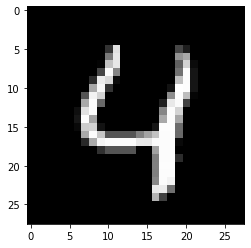

In [2]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
print('x_train shape:', x_train.shape, 'y_train shape:', y_train.shape)
plt.gray()
plt.imshow(x_test[4]);

In [3]:
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
x_train = np.reshape(x_train, x_train.shape + (1,))
x_test = np.reshape(x_test, x_test.shape + (1,))
print('x_train shape:', x_train.shape, 'x_test shape:', x_test.shape)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
print('y_train shape:', y_train.shape, 'y_test shape:', y_test.shape)

x_train shape: (60000, 28, 28, 1) x_test shape: (10000, 28, 28, 1)
y_train shape: (60000, 10) y_test shape: (10000, 10)


In [4]:
xmin, xmax = -.5, .5
x_train = ((x_train - x_train.min()) / (x_train.max() - x_train.min())) * (xmax - xmin) + xmin
x_test = ((x_test - x_test.min()) / (x_test.max() - x_test.min())) * (xmax - xmin) + xmin

In [5]:
# Simple CNN Model

In [6]:
def cnn_model():
    x_in = Input(shape=(28, 28, 1)) #input layer
    x = Conv2D(filters=64, kernel_size=2, padding='same', activation='relu')(x_in) #conv layer
    x = MaxPooling2D(pool_size=2)(x) #max pooling layer
    x = Dropout(0.3)(x) #drop out to avoid overfitting

    x = Conv2D(filters=32, kernel_size=2, padding='same', activation='relu')(x) # second conv layer
    x = MaxPooling2D(pool_size=2)(x) #max pooling layer
    x = Dropout(0.3)(x) #drop out to avoid overfitting

    x = Conv2D(filters=32, kernel_size=2, padding='same', activation='relu')(x) # third conv layer
    x = MaxPooling2D(pool_size=2)(x) #max pooling layer
    x = Dropout(0.3)(x) # drop out to avoid overfitting

    x = Flatten()(x) # flatten for reshaping the matrix
    x = Dense(256, activation='relu')(x) #this is for Fully Connected Neural Network Layer training
    x = Dropout(0.5)(x) # drop out again to avoid overfitting
    x_out = Dense(10, activation='softmax')(x) #final output layer

    cnn = Model(inputs=x_in, outputs=x_out) 
    cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return cnn

In [7]:
cnn = cnn_model()
cnn.summary()
cnn.fit(x_train, y_train, batch_size=64, epochs=5, verbose=1)
cnn.save('mnist_cnn.h5', save_format='h5')

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 64)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        8224      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 32)          0     

In [8]:
# Evaluate the model on test set

In [9]:
cnn = load_model('mnist_cnn.h5')
score = cnn.evaluate(x_test, y_test, verbose=0)
print('Test accuracy: ', score[1])

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


Test accuracy:  0.9873


In [10]:
# Define and train an Auto Encoder, it works like a principal component analysis model

In [11]:
def ae_model():
    x_in = Input(shape=(28, 28, 1))
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x_in)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    encoded = Conv2D(1, (3, 3), activation=None, padding='same')(x)

    x = Conv2D(16, (3, 3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    decoded = Conv2D(1, (3, 3), activation=None, padding='same')(x)

    autoencoder = Model(x_in, decoded)
    autoencoder.compile(optimizer='adam', loss='mse')

    return autoencoder

In [12]:
ae = ae_model()
ae.summary()
ae.fit(x_train, x_train, batch_size=128, epochs=4, validation_data=(x_test, x_test), verbose=0)
ae.save('mnist_ae.h5', save_format='h5')

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 28, 28, 16)        2320      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 14, 1)         145       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 14, 14, 16)        160       
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 28, 28, 16)        0   

In [13]:
# We can now compare the orginal image vs. auto encoder to decoder based image

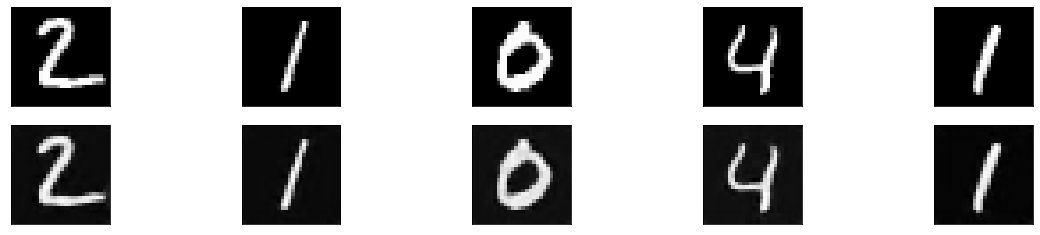

In [14]:
ae = load_model('mnist_ae.h5')

decoded_imgs = ae.predict(x_test)
n = 5
plt.figure(figsize=(20, 4))
for i in range(1, n+1):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i].reshape(28, 28))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [15]:
# Now we can explan the pertinent negative with contrastive explanations

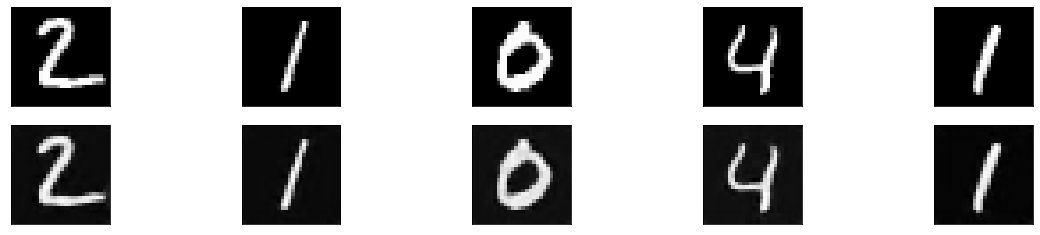

In [16]:
ae = load_model('mnist_ae.h5')

decoded_imgs = ae.predict(x_test)
n = 5
plt.figure(figsize=(20, 4))
for i in range(1, n+1):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i].reshape(28, 28))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [17]:
idx = 15
X = x_test[idx].reshape((1,) + x_test[idx].shape)

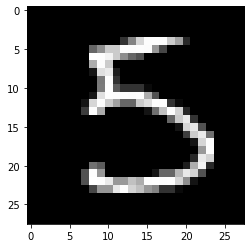

In [18]:
plt.imshow(X.reshape(28, 28));

In [19]:
# Model prediction

In [20]:
cnn.predict(X).argmax(), cnn.predict(X).max()

(5, 0.9995635)

In [21]:
# CEM parameters

In [22]:
mode = 'PN'  # 'PN' (pertinent negative) or 'PP' (pertinent positive)
shape = (1,) + x_train.shape[1:]  # instance shape
kappa = 0.  # minimum difference needed between the prediction probability for the perturbed instance on the
            # class predicted by the original instance and the max probability on the other classes
            # in order for the first loss term to be minimized
beta = .1  # weight of the L1 loss term
gamma = 100  # weight of the optional auto-encoder loss term
c_init = 1.  # initial weight c of the loss term encouraging to predict a different class (PN) or
              # the same class (PP) for the perturbed instance compared to the original instance to be explained
c_steps = 10  # nb of updates for c
max_iterations = 1000  # nb of iterations per value of c
feature_range = (x_train.min(),x_train.max())  # feature range for the perturbed instance
clip = (-1000.,1000.)  # gradient clipping
lr = 1e-2  # initial learning rate
no_info_val = -1. # a value, float or feature-wise, which can be seen as containing no info to make a prediction
                  # perturbations towards this value means removing features, and away means adding features
                  # for our MNIST images, the background (-0.5) is the least informative,
                  # so positive/negative perturbations imply adding/removing features

In [23]:
# initialize CEM explainer and explain instance
cem = CEM(cnn, mode, shape, kappa=kappa, beta=beta, feature_range=feature_range,
          gamma=gamma, ae_model=ae, max_iterations=max_iterations,
          c_init=c_init, c_steps=c_steps, learning_rate_init=lr, clip=clip, no_info_val=no_info_val)

explanation = cem.explain(X)

Pertinent negative prediction: 8


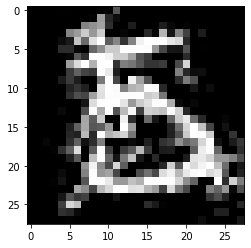

In [24]:
print(f'Pertinent negative prediction: {explanation.PN_pred}')
plt.imshow(explanation.PN.reshape(28, 28));

In [25]:
# Now Generate pertinent positive

In [26]:
mode = 'PP'

In [27]:
# initialize CEM explainer and explain instance
cem = CEM(cnn, mode, shape, kappa=kappa, beta=beta, feature_range=feature_range,
          gamma=gamma, ae_model=ae, max_iterations=max_iterations,
          c_init=c_init, c_steps=c_steps, learning_rate_init=lr, clip=clip, no_info_val=no_info_val)

explanation = cem.explain(X)

Pertinent positive prediction: 5


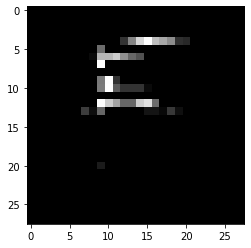

In [28]:
print(f'Pertinent positive prediction: {explanation.PP_pred}')
plt.imshow(explanation.PP.reshape(28, 28));

In [29]:
# CEM for Structured dataset

In [30]:
import tensorflow as tf
tf.get_logger().setLevel(40) # suppress deprecation messages
tf.compat.v1.disable_v2_behavior() # disable TF2 behaviour as alibi code still relies on TF1 constructs
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import to_categorical

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
from sklearn.datasets import load_iris
from alibi.explainers import CEM

print('TF version: ', tf.__version__)
print('Eager execution enabled: ', tf.executing_eagerly()) # False

TF version:  2.4.1
Eager execution enabled:  False


In [31]:
dataset = load_iris()
feature_names = dataset.feature_names
class_names = list(dataset.target_names)


In [32]:
# scaling data

In [33]:
dataset.data = (dataset.data - dataset.data.mean(axis=0)) / dataset.data.std(axis=0)

In [34]:
idx = 145
x_train,y_train = dataset.data[:idx,:], dataset.target[:idx]
x_test, y_test = dataset.data[idx+1:,:], dataset.target[idx+1:]
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [35]:
def lr_model():
    x_in = Input(shape=(4,))
    x_out = Dense(3, activation='softmax')(x_in)
    lr = Model(inputs=x_in, outputs=x_out)
    lr.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
    return lr

In [36]:
lr = lr_model()
lr.summary()
lr.fit(x_train, y_train, batch_size=16, epochs=500, verbose=0)
lr.save('iris_lr.h5', save_format='h5')

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 15        
Total params: 15
Trainable params: 15
Non-trainable params: 0
_________________________________________________________________


In [37]:
idx = 0
X = x_test[idx].reshape((1,) + x_test[idx].shape)
print('Prediction on instance to be explained: {}'.format(class_names[np.argmax(lr.predict(X))]))
print('Prediction probabilities for each class on the instance: {}'.format(lr.predict(X)))

Prediction on instance to be explained: virginica
Prediction probabilities for each class on the instance: [[3.3462059e-04 2.3820345e-01 7.6146191e-01]]


`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


In [38]:
mode = 'PN'  # 'PN' (pertinent negative) or 'PP' (pertinent positive)
shape = (1,) + x_train.shape[1:]  # instance shape
kappa = .2  # minimum difference needed between the prediction probability for the perturbed instance on the
            # class predicted by the original instance and the max probability on the other classes
            # in order for the first loss term to be minimized
beta = .1  # weight of the L1 loss term
c_init = 10.  # initial weight c of the loss term encouraging to predict a different class (PN) or
              # the same class (PP) for the perturbed instance compared to the original instance to be explained
c_steps = 10  # nb of updates for c
max_iterations = 1000  # nb of iterations per value of c
feature_range = (x_train.min(axis=0).reshape(shape)-.1,  # feature range for the perturbed instance
                 x_train.max(axis=0).reshape(shape)+.1)  # can be either a float or array of shape (1xfeatures)
clip = (-1000.,1000.)  # gradient clipping
lr_init = 1e-2  # initial learning rate

In [39]:
# define model
lr = load_model('iris_lr.h5')

# initialize CEM explainer and explain instance
cem = CEM(lr, mode, shape, kappa=kappa, beta=beta, feature_range=feature_range,
          max_iterations=max_iterations, c_init=c_init, c_steps=c_steps,
          learning_rate_init=lr_init, clip=clip)
cem.fit(x_train, no_info_type='median')  # we need to define what feature values contain the least
                                         # info wrt predictions
                                         # here we will naively assume that the feature-wise median
                                         # contains no info; domain knowledge helps!
explanation = cem.explain(X, verbose=False)


In [40]:
print(f'Original instance: {explanation.X}')
print('Predicted class: {}'.format(class_names[explanation.X_pred]))

Original instance: [[ 0.55333328 -1.28296331  0.70592084  0.92230284]]
Predicted class: virginica


In [41]:
print(f'Pertinent negative: {explanation.PN}')
print('Predicted class: {}'.format(class_names[explanation.PN_pred]))

Pertinent negative: [[ 0.5533333  -1.2829633  -0.5914936   0.92230284]]
Predicted class: versicolor


In [42]:
expl = {}
expl['PN'] = explanation.PN
expl['PN_pred'] = explanation.PN_pred

In [43]:
mode = 'PP'

In [44]:
# define model
lr = load_model('iris_lr.h5')

# initialize CEM explainer and explain instance
cem = CEM(lr, mode, shape, kappa=kappa, beta=beta, feature_range=feature_range,
          max_iterations=max_iterations, c_init=c_init, c_steps=c_steps,
          learning_rate_init=lr_init, clip=clip)
cem.fit(x_train, no_info_type='median')
explanation = cem.explain(X, verbose=False)

In [45]:
print(f'Pertinent positive: {explanation.PP}')
print('Predicted class: {}'.format(class_names[explanation.PP_pred]))

Pertinent positive: [[-7.44469730e-09 -3.47054341e-08  3.52806714e-01  8.07584572e-01]]
Predicted class: virginica


In [46]:
expl['PP'] = explanation.PP
expl['PP_pred'] = explanation.PP_pred

In [47]:
df = pd.DataFrame(dataset.data, columns=dataset.feature_names)
df['species'] = np.array([dataset.target_names[i] for i in dataset.target])

In [48]:
pn = pd.DataFrame(expl['PN'], columns=dataset.feature_names)
pn['species'] = 'PN_' + class_names[expl['PN_pred']]
pp = pd.DataFrame(expl['PP'], columns=dataset.feature_names)
pp['species'] = 'PP_' + class_names[expl['PP_pred']]
orig_inst = pd.DataFrame(explanation.X, columns=dataset.feature_names)
orig_inst['species'] = 'orig_' + class_names[explanation.X_pred]
df = df.append([pn, pp, orig_inst], ignore_index=True)

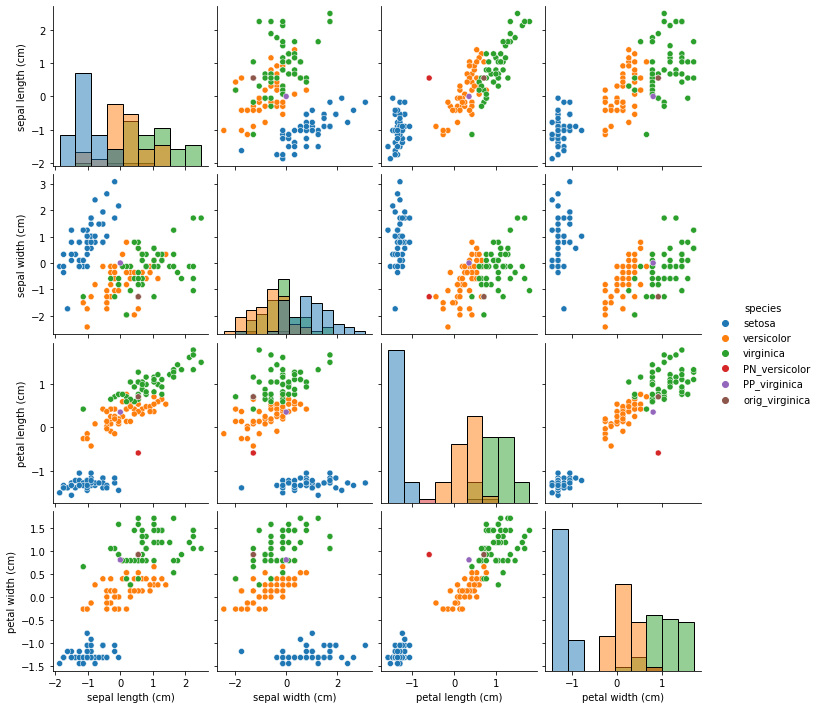

In [49]:
fig = sns.pairplot(df, hue='species', diag_kind='hist');